# Importing data & necessary packages

In [26]:
bird1 <- read.csv("eBird_Taxonomy_v2021.csv")
nrow(bird1)

[1] 16753

In [27]:
bird <- read.csv("train_metadata.csv")
head(bird)

primary_label secondary_labels               type                    latitude
1 afrsil1       []                             ['call', 'flight call'] 12.3910 
2 afrsil1       ['houspa', 'redava', 'zebdov'] ['call']                19.8801 
3 afrsil1       []                             ['call', 'song']        16.2901 
4 afrsil1       []                             ['alarm call', 'call']  17.0922 
5 afrsil1       []                             ['flight call']         21.4581 
6 afrsil1       []                             ['flight call']         21.4581 
  longitude scientific_name common_name        author        
1   -1.4930 Euodice cantans African Silverbill Bram Piot     
2 -155.7254 Euodice cantans African Silverbill Dan Lane      
3  -16.0321 Euodice cantans African Silverbill Bram Piot     
4   54.2958 Euodice cantans African Silverbill Oscar Campbell
5 -157.7252 Euodice cantans African Silverbill Ross Gallardy 
6 -157.7252 Euodice cantans African Silverbill Ross Gallardy 
  license                                                   rating time 
1 Creative Commons Attribution-NonCommercial-ShareAlike 3.0 2.5    08:00
2 Creative Commons Attribution-NonCommercial-ShareAlike 4.0 3.5    08:30
3 Creative Commons Attribution-NonCommercial-ShareAlike 4.0 4.0    11:30
4 Creative Commons Attribution-NonCommercial-ShareAlike 4.0 4.0    11:00
5 Creative Commons Attribution-NonCommercial-ShareAlike 4.0 3.0    16:30
6 Creative Commons Attribution-NonCommercial-ShareAlike 4.0 4.0    16:30
  url                               filename            
1 https://www.xeno-canto.org/125458 afrsil1/XC125458.ogg
2 https://www.xeno-canto.org/175522 afrsil1/XC175522.ogg
3 https://www.xeno-canto.org/177993 afrsil1/XC177993.ogg
4 https://www.xeno-canto.org/205893 afrsil1/XC205893.ogg
5 https://www.xeno-canto.org/207431 afrsil1/XC207431.ogg
6 https://www.xeno-canto.org/207432 afrsil1/XC207432.ogg

## Necessary packages

In [4]:
library(caret) # needed for data partitioning in validation split
library(av) # audio data reading
library(EBImage) # appending images to a dataframe 
library(jpeg) 
library(png)
library(imager)
library(caret)
library(tidyverse)

#sound reading
library(wrassp)
library(readr)
library(tuneR)
library(signal)
library(oce)
library(emuR)
library(audio)
library(viridis)
library(cowplot)

# Creating our frequency data

Idea behind creating frequency and spectogram plots that will saved to a domain and which will be further trained on. 

## Frequency plots

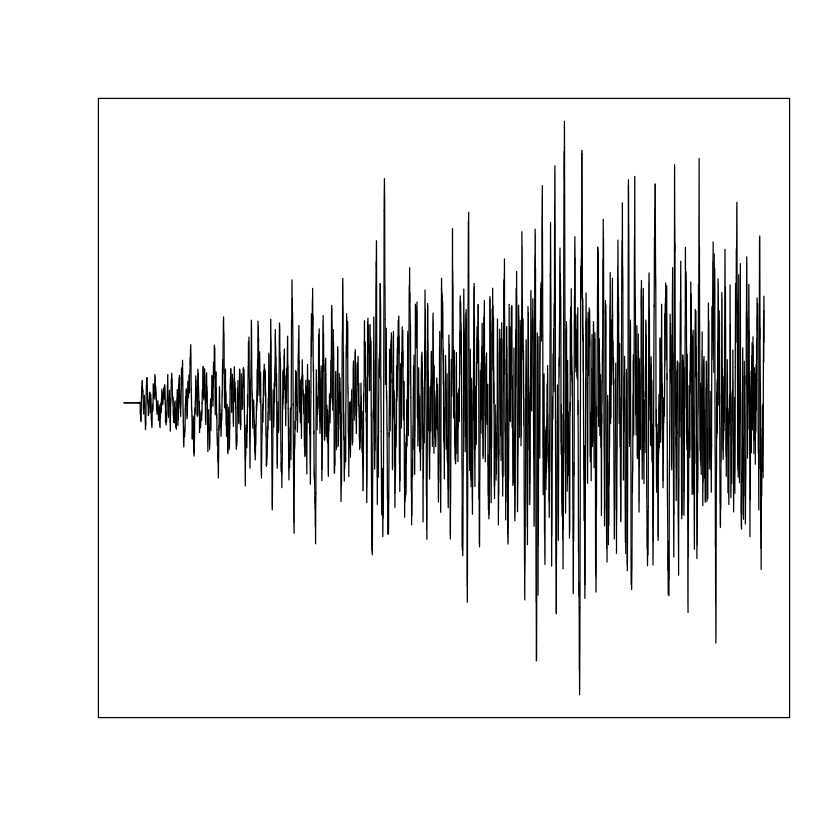

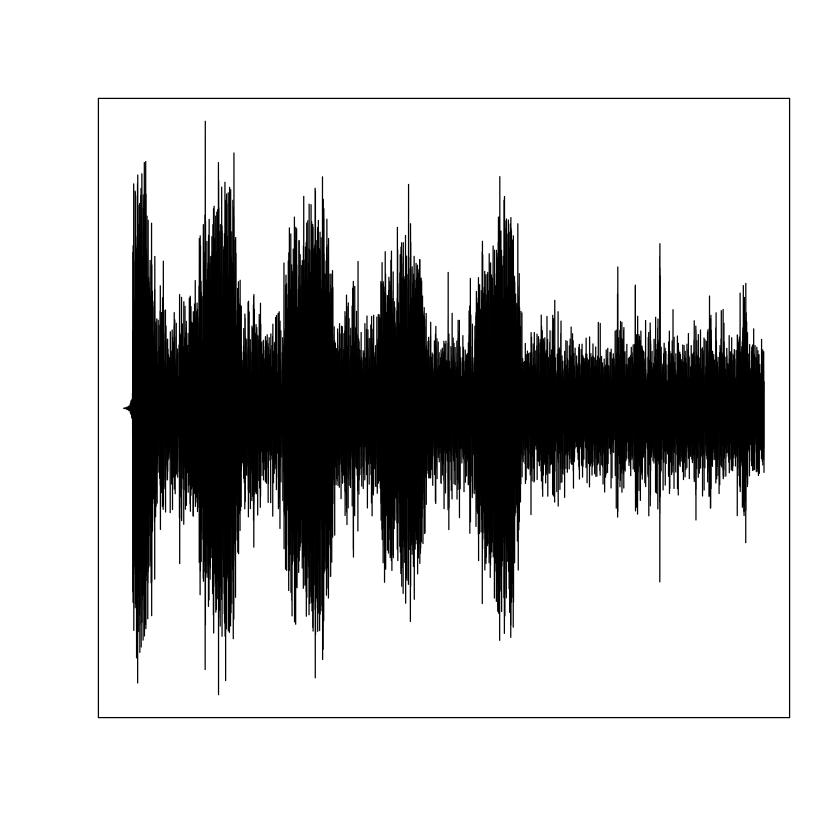

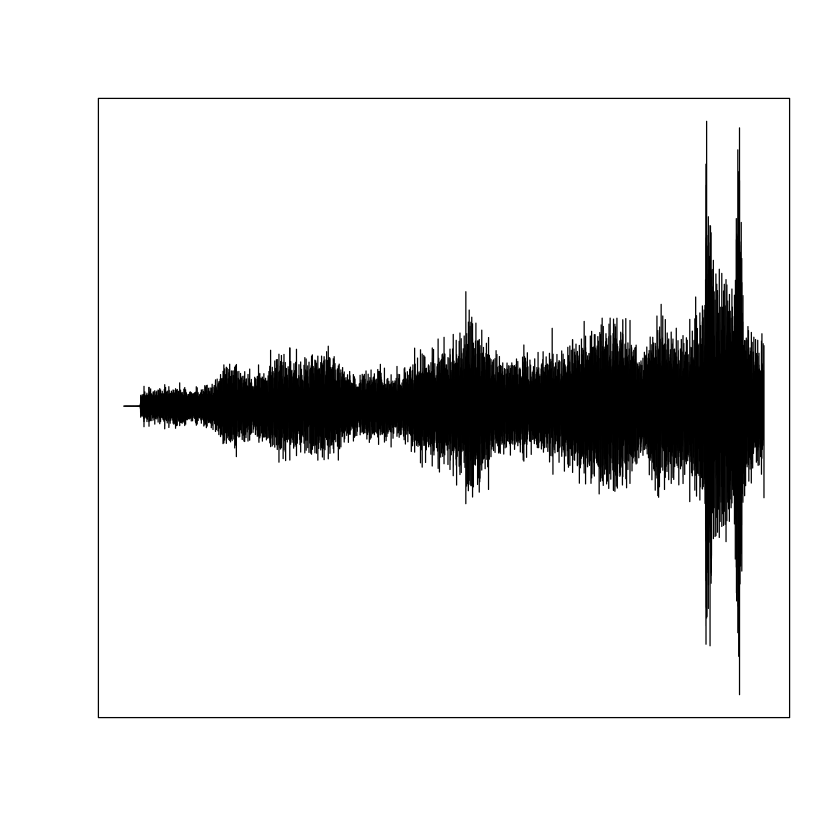

In [5]:
freq_plot <- function(n){
   
    par(bg = 'white')
    
    # making a baseline model that takes the first two seconds of every recording
    for(i in 1:n){
    plot(read_audio_bin(capture.output(cat('train_audio',bird$filename[i], sep='/')), channels = 1, end_time = 2), 
         type = 'l',axes=FALSE, frame.plot=TRUE, ann=FALSE)  
    }
}

freq_plot(3)

## Spectrogram plots

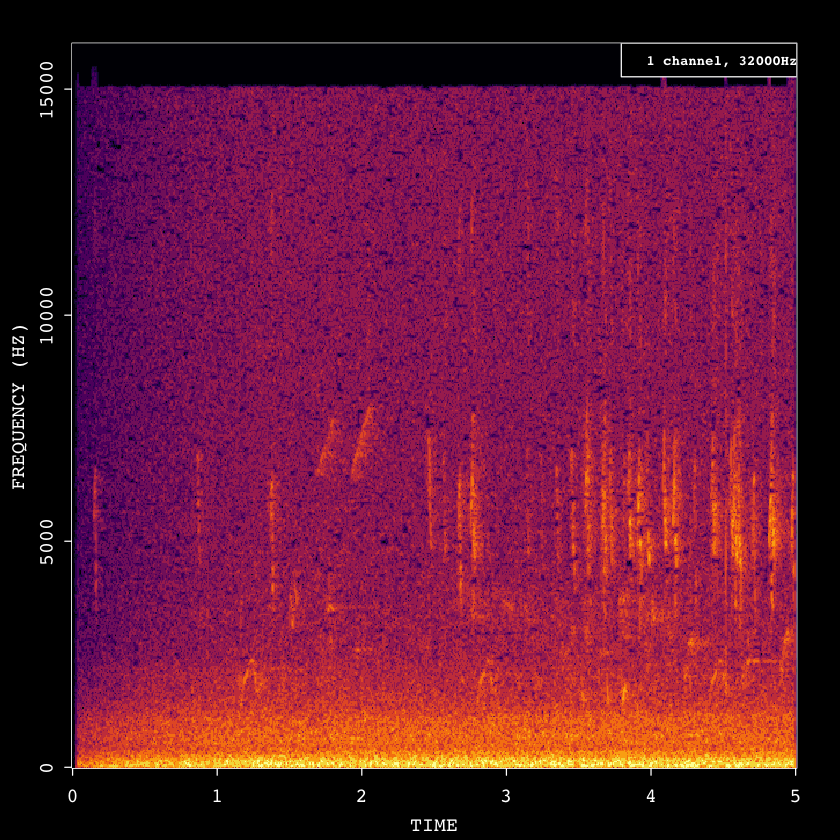

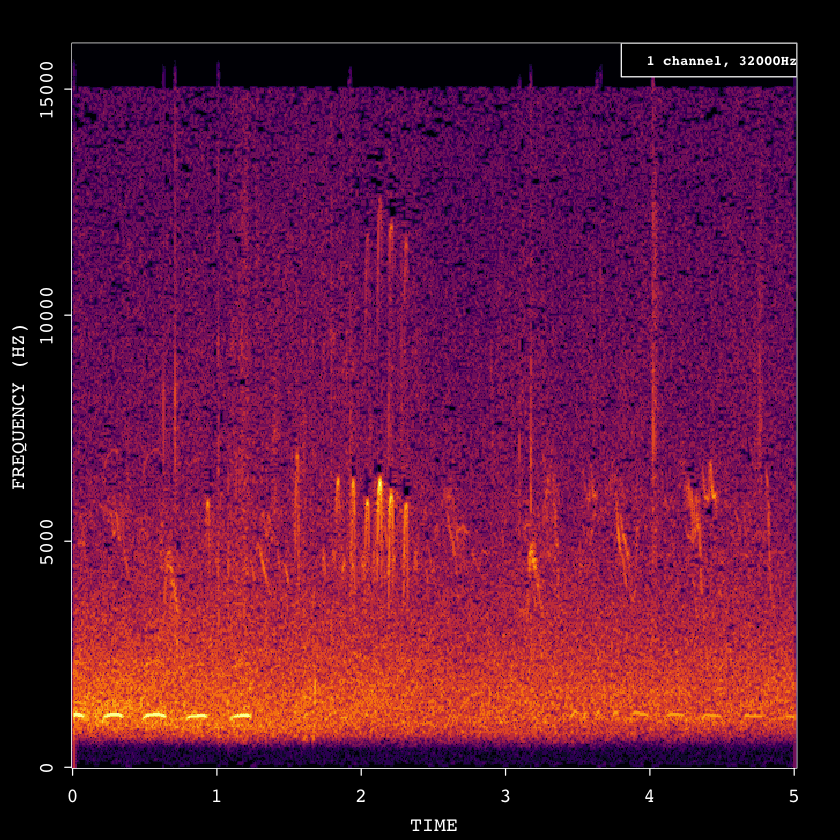

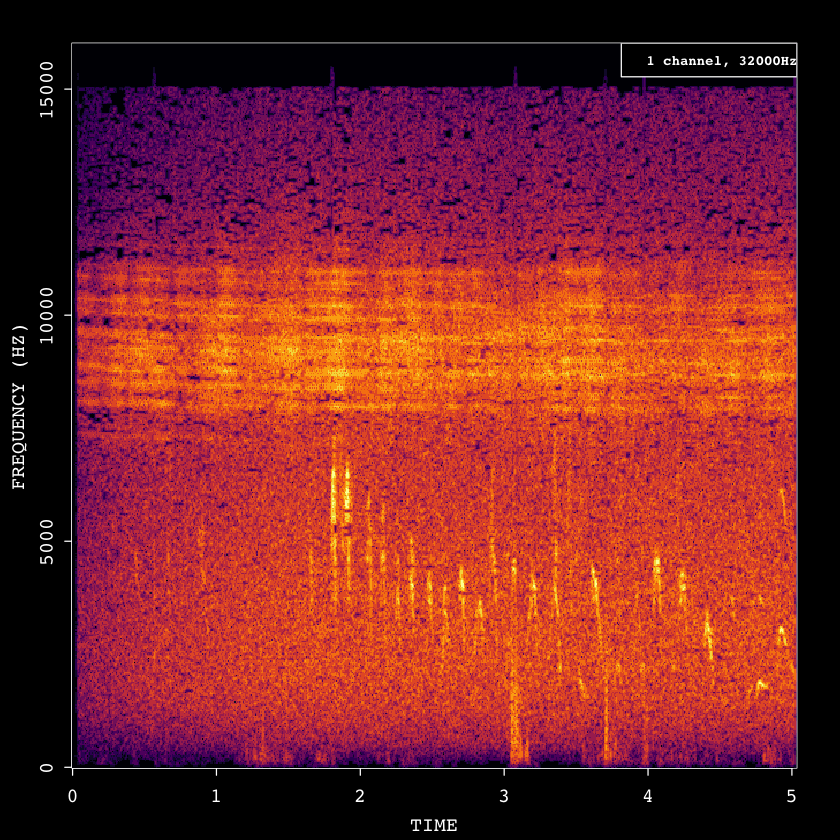

In [6]:
spectrogram_plot <- function(n){
   
    par(bg = 'white')
    
    for(i in 1:n){
    plot(read_audio_fft(capture.output(cat('train_audio',bird$filename[i], sep='/')), end_time = 5), 
         type = 'l',axes=FALSE, frame.plot=TRUE, ann=FALSE)  
    }
}

spectrogram_plot(3)

The notable problem with the above spectograms is that they would not yield appropriate classifications. The way to aid training is to transform the above spectrograms to visuals whereby the spectrograms are representative of the human auditory system. 

## Mel-frequency spectrograms

To be explored at a later stage to find optimal mel-frequency transformation. 

In [6]:
read_waves <- function(n){
# function to read the audio into callable objects    
    # creating an empty vector to be concattenated amongst the wave files 
    audio <- c()
    
    # obtaining all of the wave objects, looped over the directory of the audio files
    for(i in 1:n){
            audio <-  c(audio, 
                       Wave(
                        read_audio_bin(capture.output(cat('train_audio',bird$filename[i], sep='/')), 
                        end_time = 10,sample_rate = 32000), samp.rate = 32000, bit = 16))
        
    }

    # printing the audion objects (later to be called by the mel frequency matrices)
    audio
    
}

In [8]:
mel_freq_matrices <- function(x){
# function that takes the read audio and obtains mel frequency matrices from it 
    # prespecifying inputs to the function
    n <- length(x)
    sr <- 32000
    
    
    # creating an empty vector which will be concatenated amongst the mel frequency matrices 
    mel_freqs <- c()
    
    # for loop for the mel frequency matrices, looped over the audios read
    for(j in 1:n){
        mel_freqs[j] <- list(melfcc(x[[j]], 
                                sr = sr, 
                                numcep = 10))   
    }
  
    # printing the outputs of the mel-frequency matrices
    mel_freqs

}



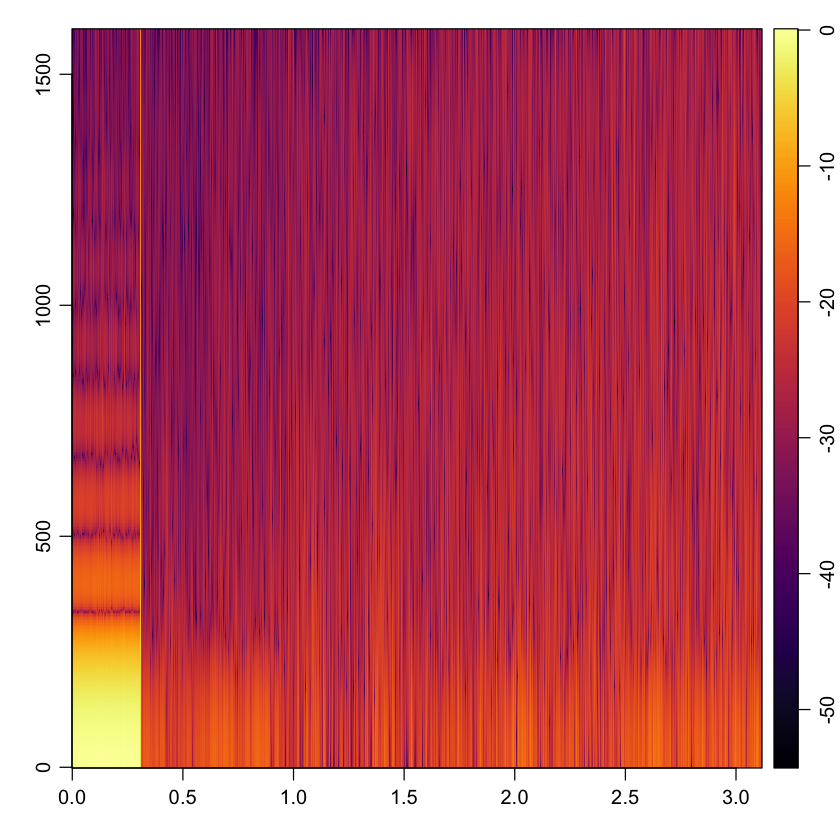

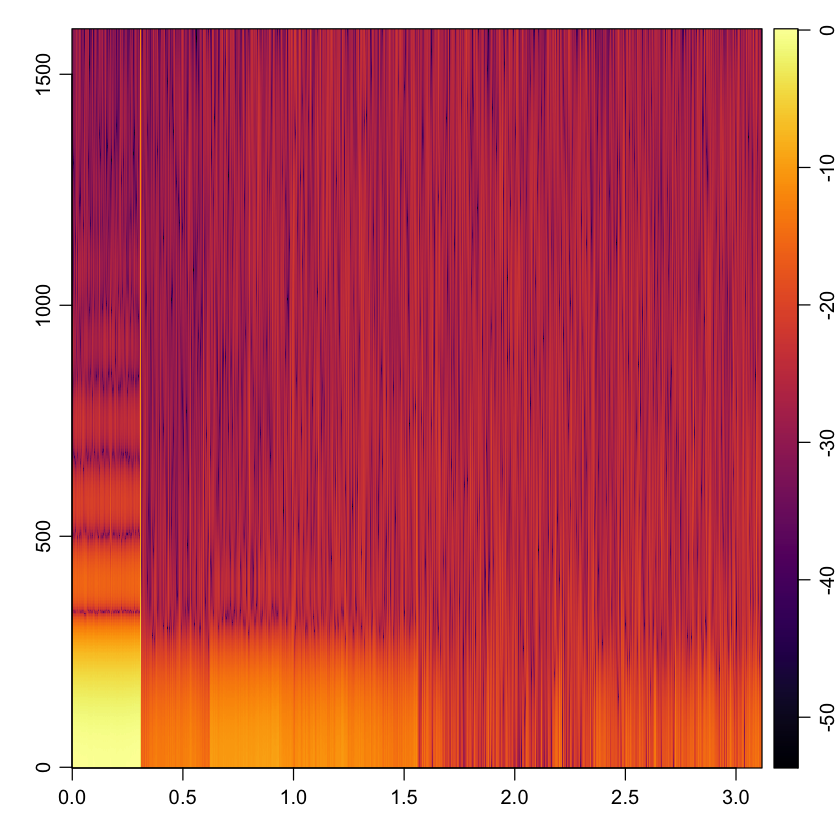

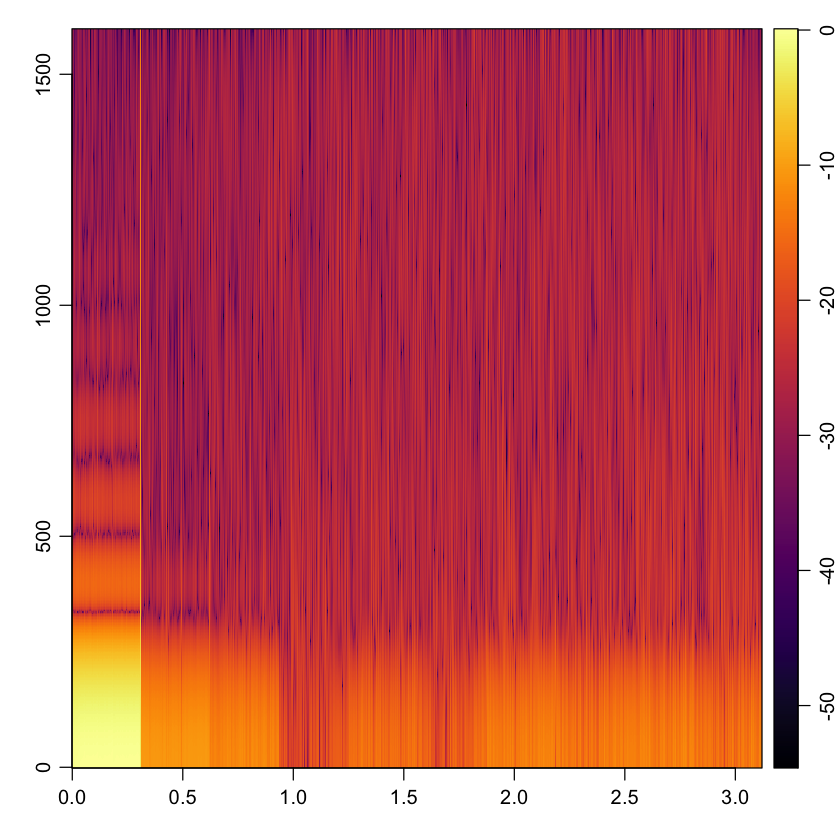

In [25]:
mel_frequency_spectrogram <- function(x){
# function which takes the mel frequency matrices and represents it as a spectrogram
    
    sr = 3200
    fft = 1020
    window = 20
    overlap = 10
    n = length(x)
    
    # spectrogram creation from the mel frequency inputs, looped over the mel frequency matrices 
    
    specto_petronas <- c()
    s <- c()
    t <- c()
    f <- c()
    
    for(i in 1:n){
        specto_petronas <-  c(specto_petronas, specgram(x = x[[i]], 
                               n = fft, 
                               Fs = sr, 
                               window = hanning(window), 
                               overlap = overlap))
    
        
    }

    # Referencing the spectrogram objects ###########################################################################
    
    # taking the spectogram matrices and performing transformations before plotting
    s_sequence <- seq(from = 1, by = 3, to = (n*3) - 2) # referencing the s matrices by sequence 
    # looping over every specto_petronas object
    
    for(j in s_sequence){
        s <- c(s, specto_petronas[j])
    }
    
    
    # Referencing the time objects ##################################################################################
    t_sequence <- seq(from = 3, by = 3, to = (n*3)) # referencing the s matrices by sequence 
    
    for(l in t_sequence){
        t <- c(t, specto_petronas[l])
    }
    
    # Referencing the frequency objects ##################################################################################
    f_sequence <- seq(from = 2, by = 3, to = (n*3)-1) # referencing the s matrices by sequence 
    
    for(h in f_sequence){
        f <- c(f, specto_petronas[h])
    }

    
    # Transformations of the mel spectrogram matrices ###############################################################
    abs_s <- list()
    norm_s <- list()
    log_s <- list()

    for(k in 1:length(s)){
        abs_s[k] <- list( abs(s[[k]])) # taking the absolute values of the fft matrices
        norm_s[k] <- list(abs_s[[k]]/max(abs_s[[k]])) # normalising the absolute valued matrices
        log_s[k] <- list(10*log10(norm_s[[k]])) # taking the log of the normalised matrices 
    }
    

    # creating the mel-spectrogram frequency plots
    par(bg = 'white')
    for(m in 1:n){
        imagep(x = (t[[m]]),
               y= t(f[[m]]),
              z = (t(log_s[[m]])), 
              col = inferno, 
              drawPalette = T,
              decimate = F)   
    }
    
    
}

mel_frequency_spectrogram(mel_freq_matrices(read_waves(3)))



In [ ]:
sr = audio@samp.rate 
sr

[1] 32000

In [42]:
mfcc.m = melfcc(audio, sr = sr,
    # wintime = 0.015,        # Window length
    # hoptime = 0.005,        # Successive windown inbetween
    numcep = 124,             # By default it will be 12 features
   #  sumpower = TRUE,        # frequence scale transformation based on powerspectrum
   #  nbands = 40,            # Number of spectra bands, filter banks
   #  bwidth = 1,             # Width of spectral bands
   #  preemph = 0.9,         # pre Emphasis
   # frames_in_rows = TRUE, 
   # minfreq = 1400,
   # maxfreq = sr/2
    )

In [179]:
# Determine duration
dur = length(mfcc.m)/audio@samp.rate
# d=Determine sample rate
fs = audio@samp.rate
## Spectrogram parameters
nfft = 1500    #Fast Fourier Transformation size can be 512 (default), 1024 or 2048.
window = 1500
overlap = 700



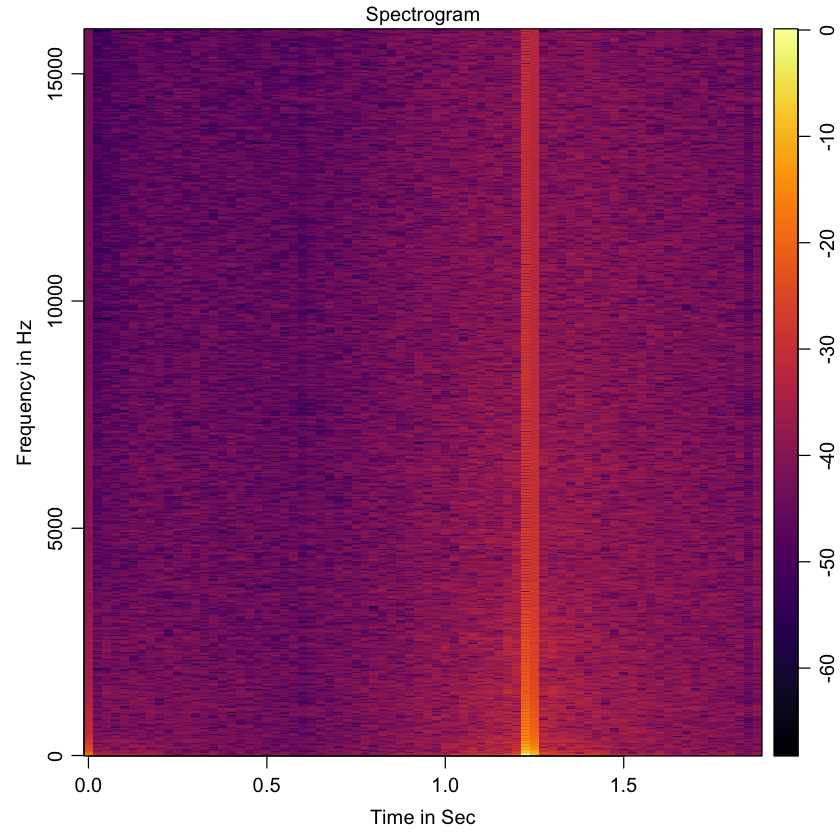

In [204]:
spectrogram = function(a) {
# Define Parameters
spec = specgram(x = a,
                n = nfft,
                Fs = fs,
                window = hanning(window),
                overlap = overlap)

    
    
P = abs(spec$S)
# Normalize
P = P/max(P)     # If we do without abs(*) it will creat NA
# Convert to dB
P = 10*log10(P)
# config time axis
t = spec$t
# plot spectrogram
    par(bg = "white")
imagep(x = t,
       y = spec$f,
       z = t(P),
       #col = oce.colorsViridis,
       #col = spectro.colors,
       col = inferno,
       ylab = 'Frequency in Hz',
       xlab = 'Time in Sec',
       main = 'Spectrogram',
       drawPalette = T,
       decimate = F)
}

spectrogram(mfcc.m)

In [149]:
library(seewave)

## Altering the spectogram output

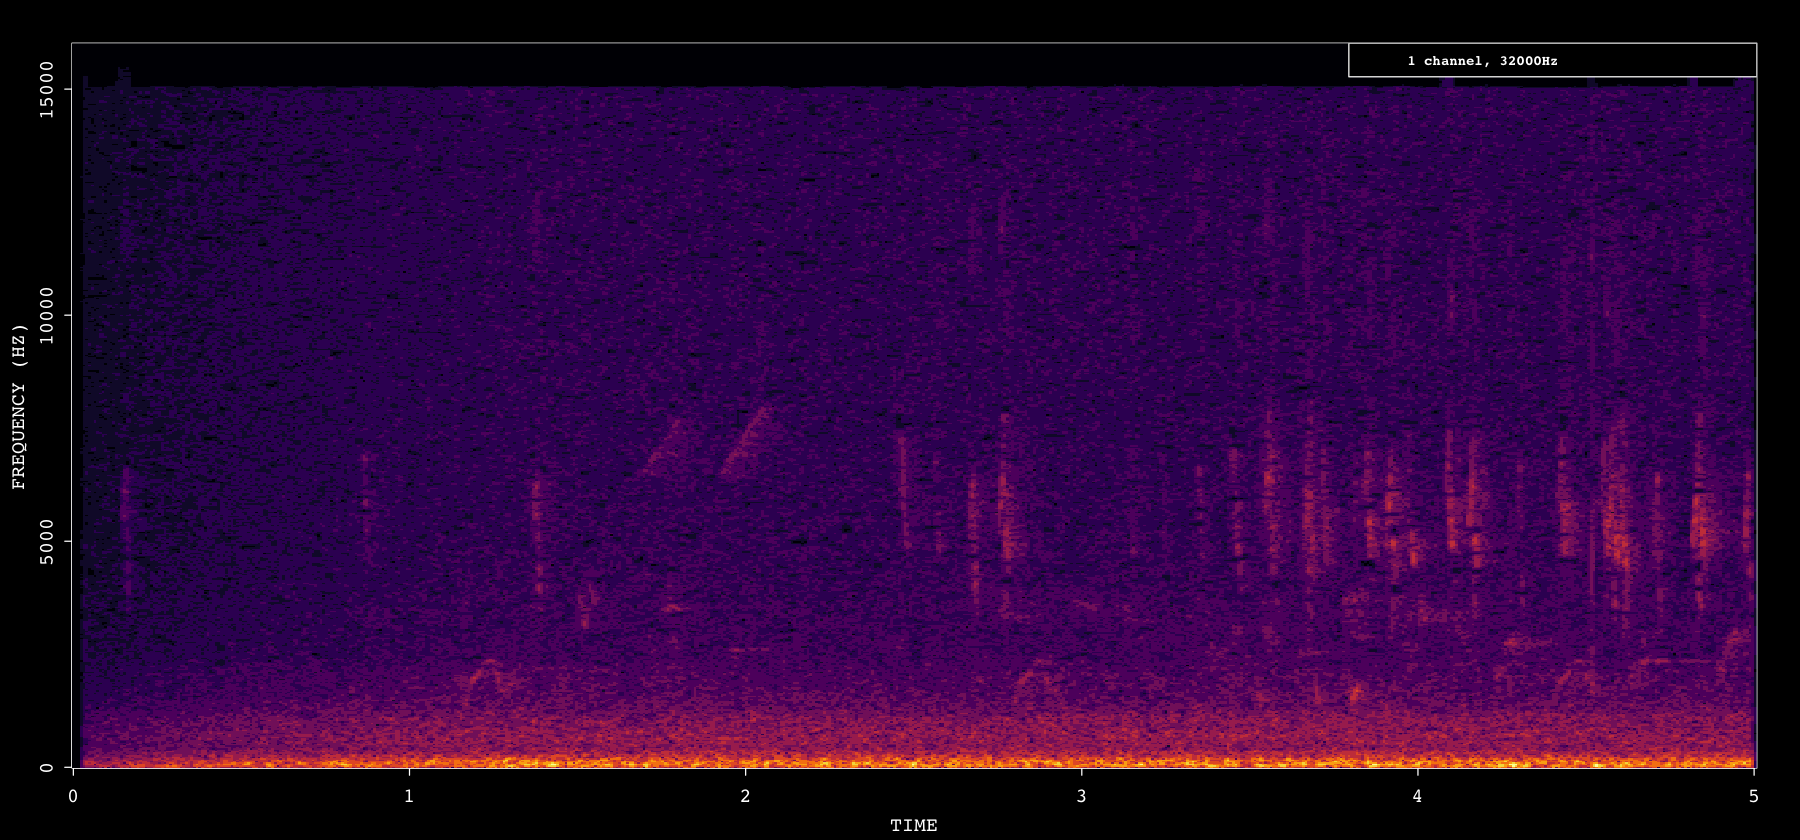

In [101]:
plot(log(read_audio_fft(capture.output(cat('train_audio',bird$filename[1], sep='/')), end_time = 5)))

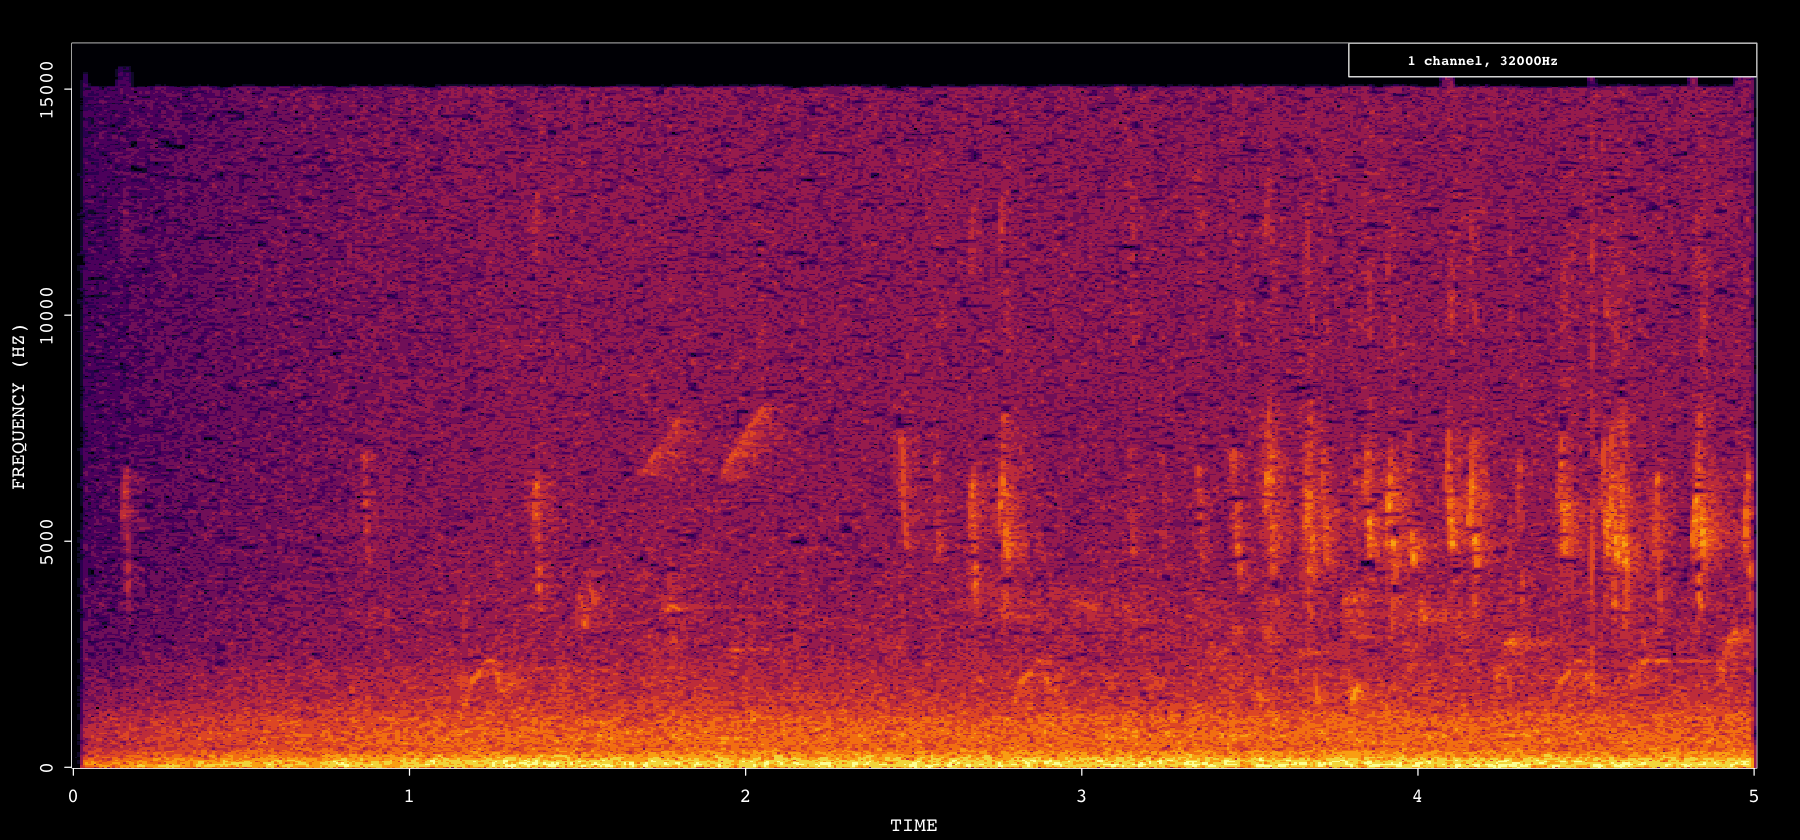

In [90]:
plot(read_audio_fft(capture.output(cat('train_audio',bird$filename[1], sep='/')), end_time = 5))

## Image representation of frequencies exported to training / validation directories

In [30]:
# saving all of the images to a subfoldered directory #############################
####################################################################################

sub_folder_images <- function(n){
    
    for(j in 1:length(unique(bird$primary_label))){
    dir.create(capture.output(cat('5sec', as.character(unique(bird$primary_label)[j]), sep = '/')))
    }
    
    
     for(i in 1:n){
        par(bg = 'white')
        
        png(filename = capture.output(cat(cat('5sec',as.character(bird$primary_label[i]), i, sep = '/'),'jpg', sep = '.')))
        
        plot(read_audio_bin(capture.output(cat('train_audio',bird$filename[i], sep='/')), channels = 1, end_time = 5), 
        type = 'l',axes=FALSE, frame.plot=TRUE, ann=FALSE)   
     
         
        dev.off()
    
    }    
    
}

sub_folder_images(nrow(bird))

In [31]:
# saving all of the spectograms to a subfoldered directory #########################
####################################################################################

sub_folder_images <- function(n){
    
    for(j in 1:length(unique(bird$primary_label))){
    dir.create(capture.output(cat('spec', as.character(unique(bird$primary_label)[j]), sep = '/')))
    }
    
    
     for(i in 1:n){
        par(bg = 'white')
        
        png(filename = capture.output(cat(cat('spec',as.character(bird$primary_label[i]), i, sep = '/'),'jpg', sep = '.')))
        
        plot(read_audio_fft(capture.output(cat('train_audio',bird$filename[i], sep='/')), end_time = 5), 
        type = 'l',axes=FALSE, frame.plot=TRUE, ann=FALSE)  
         
         
        dev.off()
    
    }    
    
}

sub_folder_images(nrow(bird))

# Flow images from directory

In [6]:
# Importing tensorflow ############################################################
library(reticulate)
options(warn=-1)

Sys.setenv(RETICULATE_PYTHON="/Users/reednaidoo/miniforge3/envs/tensorflow/bin/python")
use_python("/Users/reednaidoo/miniforge3/envs/tensorflow/bin/python")


use_condaenv('tensorflow', required=T )



library(keras)
library(tensorflow)
library(tfdatasets) 

In [7]:
folder_list <- list.files("spec/")
folder_path <- paste0("spec/", folder_list, "/")

In [8]:
# Get file name
file_name <- map(folder_path, 
                 function(x) paste0(x, list.files(x))
                 ) %>% 
  unlist()

# first 6 file name
head(file_name)

[1] "spec/afrsil1/1.jpg"  "spec/afrsil1/10.jpg" "spec/afrsil1/11.jpg"
[4] "spec/afrsil1/12.jpg" "spec/afrsil1/13.jpg" "spec/afrsil1/14.jpg"

In [9]:
# prespecifying target size for reduction of image pixelation and batch size for training 
target_size <- c(64, 64)
batch_size <- 32

In [10]:
train_data_gen <- image_data_generator(rescale = 1/255, # Scaling pixel value
                                       horizontal_flip = T, # Flip image horizontally
                                       vertical_flip = T, # Flip image vertically 
                                       rotation_range = 45, # Rotate image from 0 to 45 degrees
                                       zoom_range = 0.25, # Zoom in or zoom out range
                                       validation_split = 0.8 # 30% data as validation data
                                       )

Loaded Tensorflow version 2.7.0



In [11]:
train_image_array_gen <- flow_images_from_directory(directory = "spec/", # Folder of the data
                                                    target_size = target_size, # target of the image dimension (64 x 64)  
                                                    color_mode = "rgb", # use RGB color
                                                    batch_size = batch_size , 
                                                    seed = 1,  # set random seed
                                                    subset = "training", # declare that this is for training data
                                                    generator = train_data_gen
                                                    )

In [12]:
val_image_array_gen <- flow_images_from_directory(directory = "spec/",
                                                  target_size = target_size, 
                                                  color_mode = "rgb", 
                                                  batch_size = batch_size ,
                                                  seed = 1,
                                                  subset = "validation", # declare that this is the validation data
                                                  generator = train_data_gen
                                                  )

In [13]:
# Number of training samples
n_train <- train_image_array_gen$n

# Number of validation samples
n_val <- val_image_array_gen$n

# number of classes 
n_classes <- n_distinct(train_image_array_gen$classes)

# Building baseline model - spectrogram model

## Compiling the model

In [31]:
# Set Initial Random Weight
tensorflow::tf$random$set_seed(123)

CNN_model_1 <- keras_model_sequential(name = "CNN_1") %>% 
  
  # Convolution Layer
  layer_conv_2d(filters = 16,
                kernel_size = c(3,3),
                padding = "same",
                activation = "relu",
                input_shape = c(target_size, 3) # grayscale = 1, rgb colour = 3 
                ) %>% 

  # Max Pooling Layer
  layer_max_pooling_2d(pool_size = c(2,2)) %>% 
  
  # Flattening Layer
  layer_flatten() %>% 
  
  # Dense Layer
  layer_dense(units = 16,
              activation = "relu") %>% 
  
  # Output Layer
  layer_dense(units = n_classes,
              activation = "softmax",
              name = "Output")
  
summary(CNN_model_1)

Model: "CNN_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_4 (Conv2D)                  (None, 64, 64, 16)              448         
                                                                                
 max_pooling2d_4 (MaxPooling2D)     (None, 32, 32, 16)              0           
                                                                                
 flatten_5 (Flatten)                (None, 16384)                   0           
                                                                                
 dense_6 (Dense)                    (None, 16)                      262160      
                                                                                
 Output (Dense)                     (None, 152)                     2584        
                                                                                
Total params:

## Fitting the model

In [32]:
options(warn = 1)

In [37]:
#tensorboard("logs/run_a") 
# If wanting to open up a tensorboard 

CNN_model_1 %>% 
  compile(
    loss = "categorical_crossentropy",
    optimizer = optimizer_adam(learning_rate = 0.01),
    metrics = list(metric_categorical_accuracy())
  )

# Fit data into model
history <- CNN_model_1 %>% 
  fit(
  # training data
  train_image_array_gen,
  # training epochs
  steps_per_epoch = as.integer(n_train / batch_size), 
  epochs = 5,
  
  # validation data
  validation_data = val_image_array_gen,
  validation_steps = as.integer(n_val / batch_size), 
  verbose = 1
      
)




Started TensorBoard at http://127.0.0.1:6092 


starting httpd help server ...
 done



In [38]:
history


Final epoch (plot to see history):
                    loss: 4.417
    categorical_accuracy: 0.02831
                val_loss: 4.36
val_categorical_accuracy: 0.03379 

In [39]:
history$metrics

$loss
[1] 4.435305 4.416784 4.415273 4.414052 4.416839

$categorical_accuracy
[1] 0.02763903 0.02830503 0.02331002 0.02630703 0.02830503

$val_loss
[1] 4.366673 4.364436 4.362782 4.362276 4.360348

$val_categorical_accuracy
[1] 0.03387534 0.03125000 0.03362127 0.03387534 0.03379065

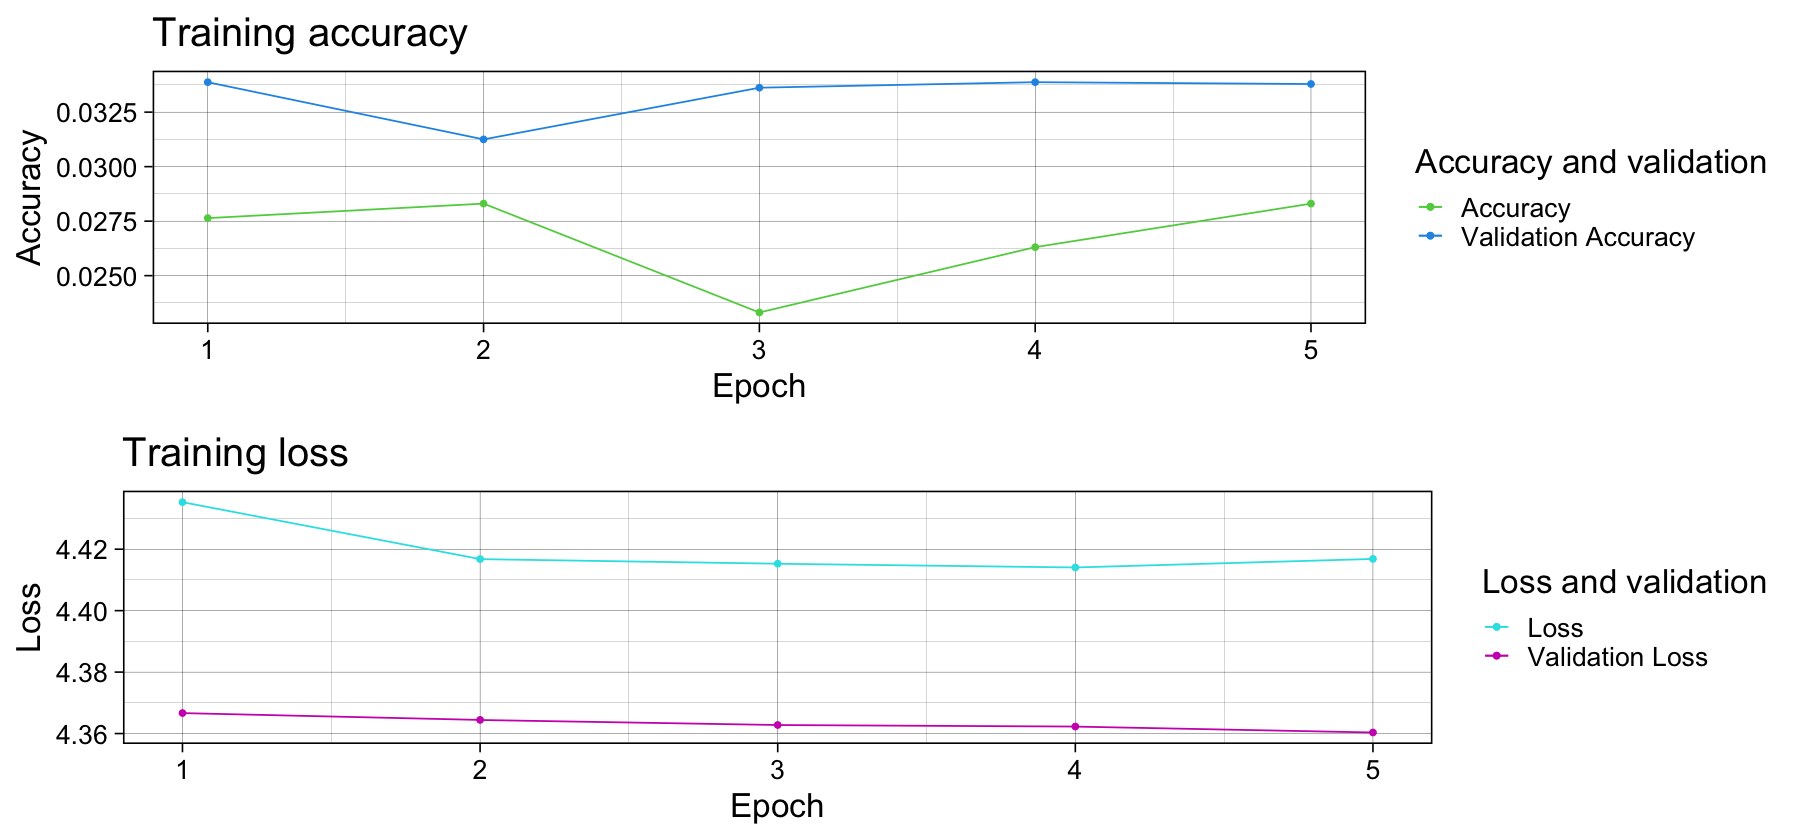

In [40]:
epoch <- c(1:5)
ggdat <- data.frame(cbind(history$metrics$categorical_accuracy, history$metrics$val_categorical_accuracy, history$metrics$val_loss, history$metrics$loss,  epoch))

colnames(ggdat) <- c("accuracy", "val_accuracy","val_loss", "loss", "epoch")




options(repr.plot.width = 15, repr.plot.height = 7)

plot1 <- ggplot(data = ggdat) +
theme_linedraw(base_size = 20) + 
labs(title = "Training accuracy", col = "Accuracy and validation")+
xlab(label = "Epoch")+
ylab(label = "Accuracy")+
geom_point(aes(x = epoch, y = accuracy, col = "Accuracy")) + 
geom_line(aes(x = epoch, y = accuracy, col = "Accuracy")) + 
geom_point(aes(x = epoch, y = val_accuracy, col = "Validation Accuracy")) +
geom_line(aes(x = epoch, y = val_accuracy, col = "Validation Accuracy"))+
scale_colour_manual(values = c(3,4))




plot2 <- ggplot(data = ggdat) +
theme_linedraw(base_size = 20) + 
labs(title = "Training loss", col = "Loss and validation")+
xlab(label = "Epoch")+
ylab(label = "Loss")+
geom_point(aes(x = epoch, y = loss, col = "Loss")) + 
geom_line(aes(x = epoch, y = loss, col = "Loss")) + 
geom_point(aes(x = epoch, y = val_loss, col = "Validation Loss")) +
geom_line(aes(x = epoch, y = val_loss, col = "Validation Loss"))+
scale_colour_manual(values = c(5,6))


plot_grid(plot1, plot2, ncol = 1, nrow = 2)
